## Open3d global Registration

In [1]:
%matplotlib widget

In [2]:


import open3d as o3d
import numpy as np
import copy
from jhutil import show_point_clouds


import logging
logging.getLogger().setLevel(logging.INFO)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    
    np_source = np.asarray(source_temp.points)
    np_target = np.asarray(target_temp.points)
    show_point_clouds([np_source, np_target])
    
    # o3d.visualization.draw_geometries([source_temp, target_temp],
    #                                   zoom-=0.4559,
    #                                   front=[0.6452, -0.3036, -0.7011],
    #                                   lookat=[1.9892, 2.0208, 1.8945],
    #                                   up=[0.2779, -0.9482, 0.1556])

In [4]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh


In [5]:
def prepare_dataset(voxel_size):
    print(":: Load two point clouds and disturb initial pose.")

    demo_icp_pcds = o3d.data.DemoICPPointClouds()
    source = o3d.io.read_point_cloud(demo_icp_pcds.paths[0])
    target = o3d.io.read_point_cloud(demo_icp_pcds.paths[1])
    trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    source.transform(trans_init)
    
    draw_registration_result(source, target, np.identity(4))
    

    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh

:: Load two point clouds and disturb initial pose.


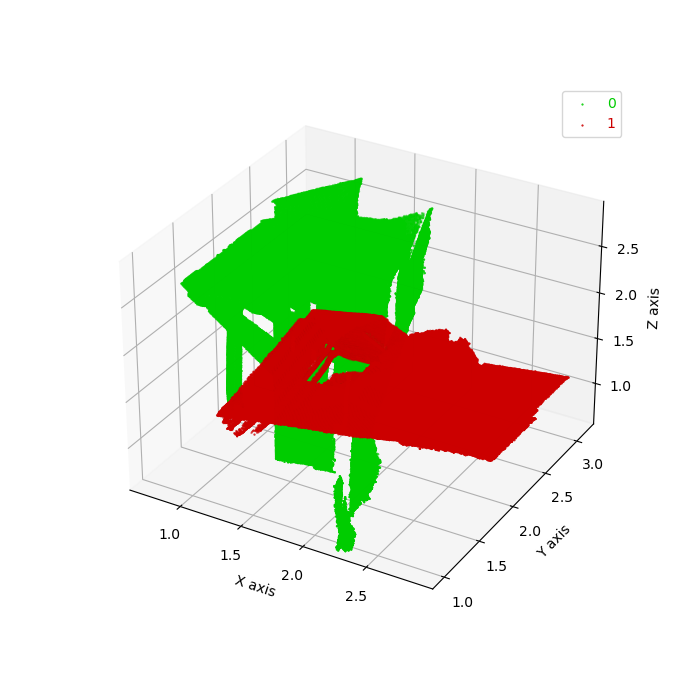

:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.


In [6]:
voxel_size = 0.05  # means 5cm for this dataset
source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(
    voxel_size)


# RanSac

In [7]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
RegistrationResult with fitness=6.756303e-01, inlier_rmse=2.714267e-02, and correspondence_set size of 3216
Access transformation to get result.


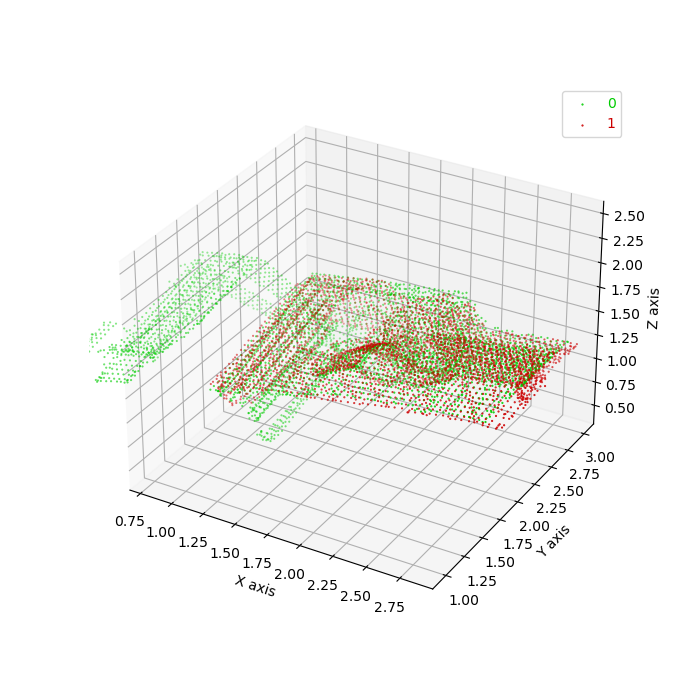

In [8]:
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
print(result_ransac)
draw_registration_result(source_down, target_down, result_ransac.transformation)

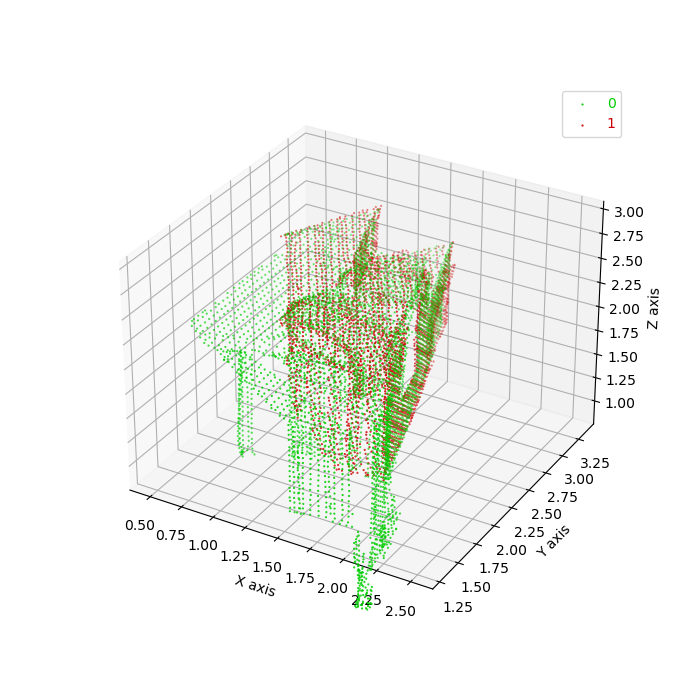

In [12]:
import torch
from jhutil import matrix_transform

np_source = torch.Tensor(source_down.points)
np_target = matrix_transform(torch.Tensor(result_ransac.transformation).inverse(), torch.Tensor(target_down.points))
show_point_clouds([np_source, np_target])

In [10]:
from jhutil import open3d_icp
import torch
result = open3d_icp(torch.Tensor(source.points), torch.Tensor(target.points), voxel_size=0.01)

:: Downsample with a voxel size 0.010.
:: Estimate normal with search radius 0.020.
:: Downsample with a voxel size 0.010.
:: Estimate normal with search radius 0.020.


# Rocal Refinement

In [17]:
def refine_registration(source, target, source_fpfh, target_fpfh, voxel_size, T):
    distance_threshold = voxel_size * 0.4
    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, T,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    return result


:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.020.
1111  "PointCloud with 198835 points."
2222  "PointCloud with 137833 points."
3333  "RegistrationResult with fitness=6.210275e-01, inlier_rmse=6.565182e-03, and correspondence_set size of 123482\nAccess transformation to get result."
RegistrationResult with fitness=6.210275e-01, inlier_rmse=6.565182e-03, and correspondence_set size of 123482
Access transformation to get result.


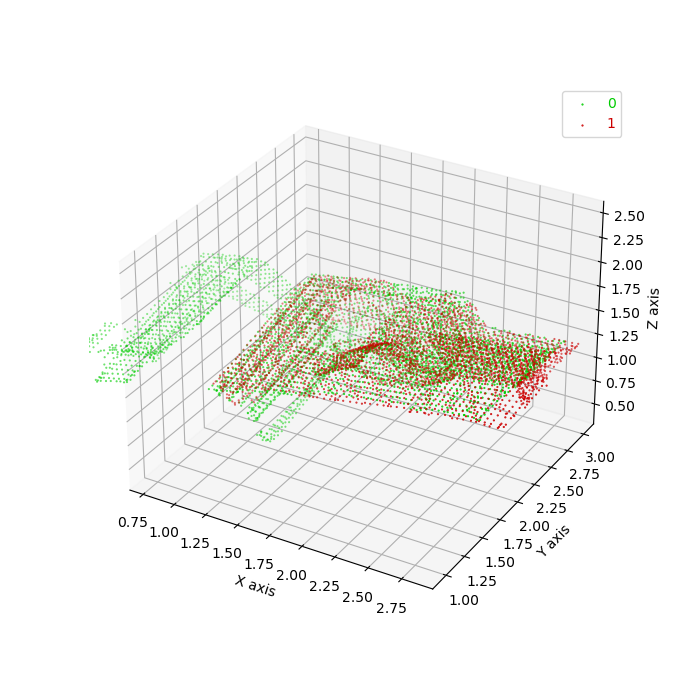

In [18]:
result_icp = refine_registration(source, target, source_fpfh, target_fpfh,
                                 voxel_size)
print(result_icp)
draw_registration_result(source_down, target_down, result_icp.transformation)


# Fast global registration

:: Load two point clouds and disturb initial pose.


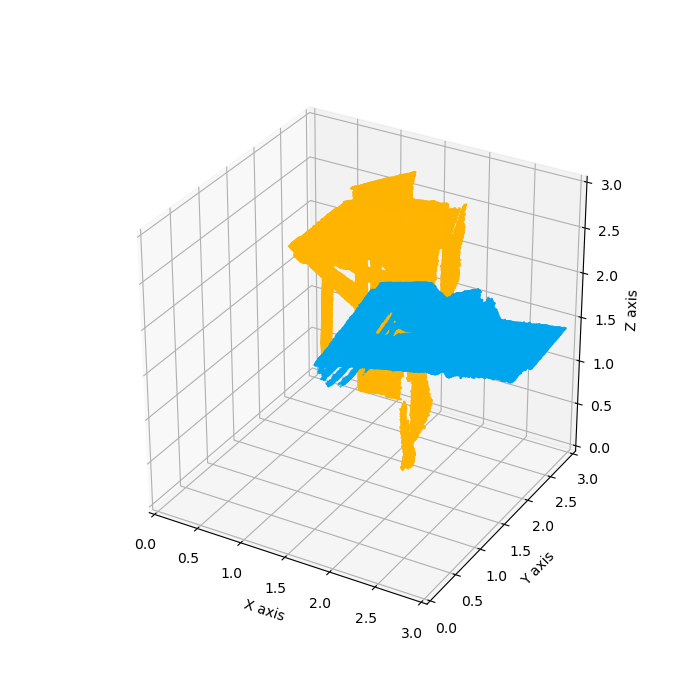

:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.


In [40]:


voxel_size = 0.05  # means 5cm for the dataset
source, target, source_down, target_down, source_fpfh, target_fpfh = \
        prepare_dataset(voxel_size)


:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
Global registration took 0.056 sec.

RegistrationResult with fitness=6.750000e-01, inlier_rmse=2.752860e-02, and correspondence_set size of 3213
Access transformation to get result.


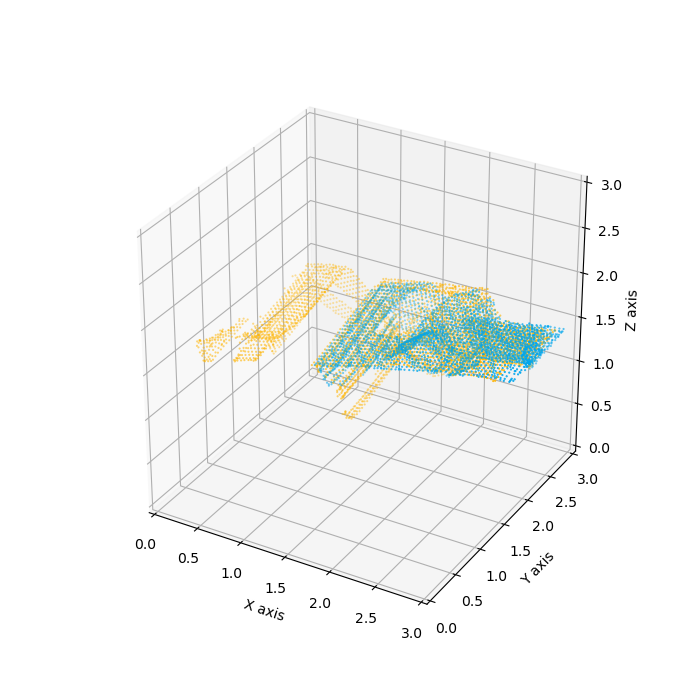

In [43]:
# 요건 ransac임

import time

start = time.time()
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
print("Global registration took %.3f sec.\n" % (time.time() - start))
print(result_ransac)
draw_registration_result(source_down, target_down, result_ransac.transformation)


In [44]:
def execute_fast_global_registration(source_down, target_down, source_fpfh,
                                     target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.5
    print(":: Apply fast global registration with distance threshold %.3f" \
            % distance_threshold)
    result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh,
        o3d.pipelines.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))
    return result


:: Apply fast global registration with distance threshold 0.025
Fast global registration took 0.170 sec.

RegistrationResult with fitness=5.079832e-01, inlier_rmse=1.741209e-02, and correspondence_set size of 2418
Access transformation to get result.


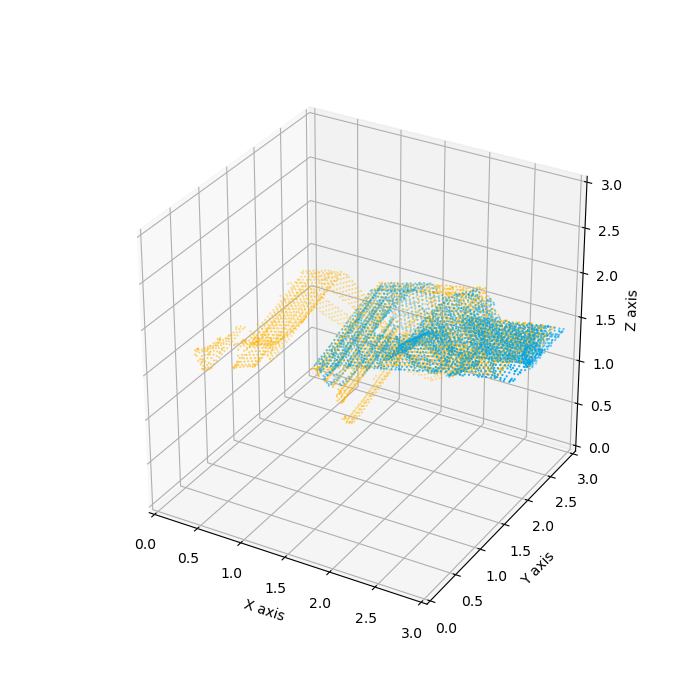

In [45]:
start = time.time()
result_fast = execute_fast_global_registration(source_down, target_down,
                                               source_fpfh, target_fpfh,
                                               voxel_size)
print("Fast global registration took %.3f sec.\n" % (time.time() - start))
print(result_fast)
draw_registration_result(source_down, target_down, result_fast.transformation)
